# Load libraries

In [4]:
#rhumba::set_channels(c("conda-forge", "default")) # Rhumba makes it easier to install packages in conda; set channels for rhumba

if (!require("psych")) rhumba::install("r-psych")
if (!require("dplyr")) rhumba::install("r-dplyr")
if (!require("ggplot2")) rhumba::install("r-ggplot2")
if (!require("car")) rhumba::install("r-car")
if (!require("janitor")) rhumba::install("r-janitor")
if (!require("readxl")) rhumba::install("r-readxl")
if (!require("remotes")) rhumba::install("r-remotes")
#if (!require("hmisc")) rhumba::install("r-hmisc")
if (!require("ggpubr")) rhumba::install("r-ggpubr")
if (!require("ggseg")) install.packages("ggseg")
if (!require("ggseg3d")) install.packages("ggseg3d")
#remotes::install_github("LCBC-UiO/ggsegDKT", auth_token='PLACE TOKEN HERE')
library(ggsegDKT)
if (!require("plotly")) install.packages("plotly")
if (!require("flextable")) install.packages("flextable")
if (!require("Hmisc")) rhumba::install("r-Hmisc")
library('matrixStats')
library(effectsize)

Loading required package: psych

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:psych’:

    logit


Loading required package: janitor


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: readxl

Loading required package: remotes

Loading required package: ggpubr

Loading required package: ggseg

Loading required package: ggseg3d

Loading required package: plotly


Attachi

In [5]:
# Custom function to round and format values
round_and_format <- function(x, digits = 4, threshold = 0.0001) {
  # Round the values first
  x_rounded <- round(x, digits)
  
  # Format values in scientific notation if they are below the threshold and non-zero
  x_formatted <- ifelse(abs(x) < threshold & abs(x) > 0, format(x, scientific = TRUE, digits = digits), x_rounded)
  
  return(x_formatted)
}


# Read in data

In [6]:
data=read.csv('/dagher/dagher11/filip/MAPT_OB//data/dataset_excluded_new.csv', header=T, quote='"')
data$genotype=NULL

In [7]:
fmnl2=read.table('/dagher/dagher11/filip/MAPT_OB/data/UKBB_filip_2SNPs.csv', sep=',', header=TRUE)
AD_PRS=read.table('/dagher/dagher11/filip/MAPT_OB/data/UKB_AD_PRScs_zscored.csv', sep=',')
colnames(AD_PRS)=c('eid','eid2','AD_PRS')

In [8]:
data=merge(data, fmnl2, by.x='eid', by.y='FID', all.x=T)
data=merge(data, AD_PRS, by='eid', all.x=T)

# Clean data, define functions and variables

In [9]:
columns_to_check <- c("body_mass_index_bmi_21001.2.0", "age_when_attended_assessment_centre_21003.2.0",
                     'sex_31.0.0', 'date_of_attending_assessment_centre_53.2.0','uk_biobank_assessment_centre_54.2.0',
                     'genotype_measurement_batch_22000.0.0',
                     colnames(data[grep('genetic_principal',colnames(data))][1:15]))

# Remove rows with NA values in the specified columns
data <- data[complete.cases(data[, columns_to_check]), ]

In [10]:
data$number_of

NULL

In [11]:
data$RT=rowMeans(data[grep('snap.button', colnames(data))], na.rm=T) #reaction time
data$Pairs=rowMeans(data[grep('number_of_incorrect_matches_in_round', colnames(data))], na.rm=T) #visuospatial memory
data$Prospective_memory<-(as.numeric(factor(car::recode(data$prospective_memory_result_20018.2.0, 
                                         "'Correct recall on first attempt'='1'; 
                                        'Correct recall on second attempt'='2';
                                        'Instruction not recalled, either skipped or incorrect'='3'"), ordered=TRUE)))

cog=c('RT','Pairs','Prospective_memory','fluid_intelligence_score_20016.2.0',
      'maximum_digits_remembered_correctly_4282.2.0', 'number_of_puzzles_correct_21004.2.0') # 21004 - executive function

# 6374 - another aspect but not included here for now

In [12]:
psych::describe(data$age_when_attended_assessment_centre_21003.2.0)
psych::describe(data$body_mass_index_bmi_21001.2.0)
table(data$sex_31.0.0)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,33769,64.20545,7.685483,65,64.30466,8.8956,45,83,38,-0.1165048,-0.8121213,0.0418227


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,33769,26.20757,3.970484,25.7439,25.95695,3.774551,13.388,40.0949,26.7069,0.6195729,0.4059086,0.0216065



Female   Male 
 17210  16559 

In [13]:
plot_struct=c('caudal anterior cingulate','caudal middle frontal','cuneus','entorhinal','fusiform','inferior parietal',
 'inferior temporal','isthmus cingulate','lateral occipital','lateral orbitofrontal','lingual',
 'medial orbitofrontal','middle temporal','parahippocampal','paracentral','pars opercularis','pars orbitalis',
 'pars triangularis','pericalcarine','postcentral','posterior cingulate','precentral','precuneus',
 'rostral anterior cingulate','rostral middle frontal','superior frontal','superior parietal','superior temporal',
 'supramarginal', 'transverse temporal','insula')

## Create a cardiometabolic risk score variable

In [14]:
vars_pca=data.frame(data$c.reactive_protein_30710.0.0, data$`glucose_30740.0.0`, data$`glycated_haemoglobin_hba1c_30750.0.0`, 
                    data$`systolic_blood_pressure_automated_reading_4080.0.0`,
                   data$`diastolic_blood_pressure_automated_reading_4079.0.0`, data$`triglycerides_30870.0.0`, 
                    data$`body_mass_index_bmi_21001.2.0`, data$`body_fat_percentage_23099.2.0`,
                   data$`waist_circumference_48.2.0`/data$`hip_circumference_49.2.0`, data$ldl_direct_30780.0.0, 
                    data$`cholesterol_30690.0.0`, data$`hdl_cholesterol_30760.0.0`)

In [15]:
ncol(vars_pca)

[1] 12

In [16]:
vars_pca=scale(vars_pca)

In [17]:
a=principal(vars_pca, nfactors=1, scores = TRUE, rotate="varimax")

In [16]:
b=as.data.frame(unclass(a$loadings))

In [17]:
a

Principal Components Analysis
Call: principal(r = vars_pca, nfactors = 1, rotate = "varimax", scores = TRUE)
Standardized loadings (pattern matrix) based upon correlation matrix
                                                                PC1    h2   u2
data.c.reactive_protein_30710.0.0                              0.46 0.208 0.79
data.glucose_30740.0.0                                         0.22 0.050 0.95
data.glycated_haemoglobin_hba1c_30750.0.0                      0.30 0.092 0.91
data.systolic_blood_pressure_automated_reading_4080.0.0        0.56 0.314 0.69
data.diastolic_blood_pressure_automated_reading_4079.0.0       0.60 0.366 0.63
data.triglycerides_30870.0.0                                   0.65 0.429 0.57
data.body_mass_index_bmi_21001.2.0                             0.65 0.428 0.57
data.body_fat_percentage_23099.2.0                             0.21 0.045 0.96
data.waist_circumference_48.2.0.data.hip_circumference_49.2.0  0.61 0.371 0.63
data.ldl_direct_30780.0.0       

In [18]:
png('/dagher/dagher11/filip/MAPT_OB/figures/FigS1.png',width=2500, height=2500, res=300)
screeplot=data.frame('Eigenvalues'=a$values, 'Index'=as.factor(c(1:12)))
ggplot(data=screeplot, aes(y=Eigenvalues, x=Index)) + 
geom_point(size=3) + 
geom_line(aes(x=as.numeric(Index))) +
theme_classic() + 
theme(text = element_text(size=12)) + xlab('Component')
dev.off()

png 
  2

In [19]:
data$pca1=a$scores[,1]
#data$pca2=a$scores[,2]
#data$pca3=a$scores[,3]

## Create genotype variables

In [20]:
#data=data[!(data$body_mass_index_bmi_21001.2.0>35 | is.na(data$body_mass_index_bmi_21001.2.0)),]

In [18]:
data$E4=dplyr::recode(data$haplotype_APOE, 'Apo-Îµ3/Îµ3'=0, 'Apo-Îµ3/Îµ4'=1, 'Apo-Îµ2/Îµ3'=0,
'Apo-Îµ1/Îµ3'=0, 'Apo-Îµ4/Îµ4'=1, 'Apo-Îµ2/Îµ2'=0)
data$H1=dplyr::recode(data$haplotype_MAPT, '0'=1, '1'=0, '2'=0)
data$rs57223657=dplyr::recode(data$rs57223657, 'GG'=0, 'TG'=1, 'TT'=1)
data$rs6760139=dplyr::recode(data$rs6760139, 'CC'=0, 'CG'=1, 'GG'=2)

table(data$E4)
table(data$H1)
table(data$rs57223657)
table(data$rs6760139)

Warning message:
“Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`.”
Warning message:
“Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`.”



    0     1 
25049  8666 


    0     1 
13355 20337 


    0     1 
30307  3122 


    0     1     2 
 4413 15509 13598 

In [19]:
#data$TSA=rowSums(data[c(grep('area_of',colnames(data)))])

## Create a function to run lm with appropriate covariates while defining outcome variables of interest

In [20]:
ctx_model = function(phenotype, genotype, term, VoI, label){
   
    if (phenotype=='cortex'){
        results=matrix(ncol=9,nrow=length(c(grep('area_of',colnames(data)),
                                   grep('thickness_of',colnames(data)))))
        
        for (i in 1:length(c(grep('area_of',colnames(data)),
                    grep('thickness_of',colnames(data))))) 
            { 
            
            if (term=='main'){

                if (i<63){
                
                m=(lm(data[c(grep('area_of',colnames(data)), grep('area_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) +
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                } else {

                m=(lm(data[c(grep('thickness_of',colnames(data)), grep('thickness_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) +
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                }
                    
                    m1=summary(m)

                            results[i,1]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,2]=m1$coefficients[2,4] # p-value 
                            results[i,3]=m1$coefficients[2,3] # t-value 
                            results[i,4]=m1$coefficients[2,1] # sd for 
                            results[i,5]=m1$coefficients[2,2] # estimate for 
                            results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                            results[i,7]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,8]=m1$df[2]+m1$df[1] #
                            results[i,9]=eta_squared(m)$Eta2_partial[2]

                }
            
            else if (term=='int'){

                if (i<63){
            
                m=(lm(data[c(grep('area_of',colnames(data)), grep('area_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) *
                          unlist(data[genotype]) + 
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

                } else {

                m=(lm(data[c(grep('thickness_of',colnames(data)), grep('thickness_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) *
                          unlist(data[genotype]) + 
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                }
                
                m1=summary(m)

                            results[i,1]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,2]=m1$coefficients[131,4] # p-value 
                            results[i,3]=m1$coefficients[131,3] # t-value 
                            results[i,4]=m1$coefficients[131,1] # sd for 
                            results[i,5]=m1$coefficients[131,2] # estimate for 
                            results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                            results[i,7]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,8]=m1$df[2]+m1$df[1] # 
                            results[i,9]=eta_squared(m)$Eta2_partial[23]
                

            }
                    }

            results[1:62,2]=p.adjust(results[1:62,2], method='BH')
            results[63:124,2]=p.adjust(results[63:124,2], method='BH')
            results=as.data.frame(results)
            results$measure=c(rep('Area', 62),rep('Thickness',62))
            colnames(results)=c('region','p','t','Estimate','SE','hemi','orig_label','Sample size','Partial_E2','phenotype')
            results$t=as.numeric(results$t)
            results$p=as.numeric(results$p)
            results$SE=as.numeric(results$SE)
            results$Estimate=as.numeric(results$Estimate)
            results$Partial_E2=as.numeric(results$Partial_E2)
            results$region=rep(plot_struct,4)

            plot_brain = results[results$p<0.05,] %>%
              group_by(phenotype) %>%
              ggplot() + geom_brain(atlas = dkt, 
                         #position = position_brain(hemi ~ side),
                         aes(fill = t, color=I("darkgrey"))) +              
                         facet_wrap(.~phenotype, nrow=2) +
                         #ggtitle(label) + 
                         theme_minimal() +
                         theme(axis.text.y = element_blank(),
                               axis.text.x = element_blank(),
                               strip.background =element_rect(fill="white", colour='white'),
                               strip.text = element_text(colour = 'black', family="Arial"),
                               plot.title = element_text(hjust = 0.5, family="Arial"),
                               legend.position="bottom",
                               panel.grid.major = element_blank(), 
                               panel.grid.minor = element_blank()) + scale_fill_gradient2(midpoint=0, low="#00203FFF", mid="white",
                                 high="#ADEFD1FF", space ="Lab", na.value='white')
    
            results=results %>% 
            mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
            tab=flextable(results[,c(1,6,2:3,8:10)])
            tab=autofit(tab, add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
            if (term=='main'){
            tab=set_caption(tab, caption = paste("Table S - GM and", label, "associations", sep=' '))}
            else if (term=='int'){
            tab=set_caption(tab, caption = paste("Table S - GM*",label, "and", genotype, 'associations', sep=' '))}
    
            data$meanThickVoI=rowMeans(data[results[results$p<0.05,][as.numeric(grep('thickness', results[results$p<0.05,]$orig_label)),]$orig_label],na.rm=T)
            data$meanAreaVoI=rowMeans(data[results[results$p<0.05,][as.numeric(grep('area', results[results$p<0.05,]$orig_label)),]$orig_label],na.rm=T)

            #data=data %>% 
            #mutate(quantilegroup = ntile(body_mass_index_bmi_21001.2.0, 10)) 

            na_dat=!is.na(data[genotype])
            data$genotype_interest=data[[genotype]]
            CTbox = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanThickVoI, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean CT in regions related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

            SAbox = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanAreaVoI, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean SA in regions related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

        return(list(tab, plot_brain, CTbox, SAbox, results))
    }
    
    else if (phenotype=='subcortex'){
        
        results=matrix(ncol=8,nrow=length(grep('volume_of',colnames(data))[c(1:14)])) 

        for (i in 1:length(c(grep('volume_of',colnames(data))[c(1:14)]))) 
        { 
            if (term=='main'){

                m=(lm(data[grep('volume_of',colnames(data))[c(1:14)]][[i]]/
                                   data$volume_of_estimatedtotalintracranial_whole_brain_26521.2.0 ~ 
                      unlist(data[VoI]) +
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                               min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, raw=TRUE) +
                      data$uk_biobank_assessment_centre_54.2.0 +
                      #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                      #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                
                m1=summary(m)

                        results[i,1]=colnames(data)[grep('volume_of',colnames(data))[c(1:14)]][i] 
                        results[i,2]=m1$coefficients[2,4] # p-value for BMI*haplotype interaction
                        results[i,3]=m1$coefficients[2,3] # F-value for BMI*haplotype interaction
                        results[i,4]=m1$coefficients[2,1] # SS for BMI*haplotype interaction
                        results[i,5]=m1$coefficients[2,2] # DF for BMI*haplotype interaction
                        results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                        results[i,7]=m1$df[2]+m1$df[1]
                        results[i,8]=eta_squared(m)$Eta2_partial[2]

                
                        }

            if (term=='int'){

                m=(lm(data[grep('volume_of',colnames(data))[c(1:14)]][[i]]/
                                   data$volume_of_estimatedtotalintracranial_whole_brain_26521.2.0 ~ 
                      unlist(data[VoI]) *
                      unlist(data[genotype]) + 
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                               min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, raw=TRUE) +
                      data$uk_biobank_assessment_centre_54.2.0 +
                      #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                      #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
              
                m1=summary(m)

                        results[i,1]=colnames(data)[grep('volume_of',colnames(data))[c(1:14)]][i] 
                        results[i,2]=m1$coefficients[131,4] # p-value for BMI*haplotype interaction
                        results[i,3]=m1$coefficients[131,3] # F-value for BMI*haplotype interaction
                        results[i,4]=m1$coefficients[131,1] # est for BMI*haplotype interaction
                        results[i,5]=m1$coefficients[131,2] # se for BMI*haplotype interaction
                        results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                        results[i,7]=m1$df[2]+m1$df[1] 
                        results[i,8]=eta_squared(m)$Eta2_partial[23]

                

                        }

        }

                results[,2]=p.adjust(results[,2], method='BH')
                results=as.data.frame(results)
                colnames(results)=c('label','p','t','Estimate','SE','hemisphere','Sample size','Partial_E2')
                results$t=as.numeric(results$t)
                results$p=as.numeric(results$p)
                results$Partial_E2=as.numeric(results$Partial_E2)
                #results$region=c('WMH',rep(c('thalamus proper','caudate','putamen','pallidum','hippocampus','amygdala',
                #                             'accumbens area'),2))
                results$label=c('Left-Thalamus-Proper','Right-Thalamus-Proper','Left-Caudate','Right-Caudate',
                                'Left-Putamen','Right-Putamen','Left-Pallidum','Right-Pallidum',
                                'Left-Hippocampus','Right-Hippocampus','Left-Amygdala','Right-Amygdala',
                                'Left-Accumbens-area','Right-Accumbens-area')

                #sig=results[results$p<0.05,]
                #sig
                #ggseg3d(.data = sig, atlas = aseg_3d, 
                #        colour = "t", text = "t", 
                #        na.alpha= .2,
                #        options.legend = list(title=list(text="t-value"))) %>% 
                #        remove_axes() %>% 
                #  add_glassbrain(opacity=0.2) %>% 
                #  layout(paper_bgcolor='white', 
                #         font=list(color='black', family='arial'),
                #        width = 1, height = 1)

                #results=results[!results$label=='WMH',]

                sub_plot = results[results$p<0.05,] %>% 
                  ggplot() + geom_brain(atlas = aseg, 
                             #position = position_brain(hemi ~ side),
                             aes(fill = t, color=I("black")), side = "coronal") +              
                             #ggtitle(paste(label, '', sep='')) + 
                             theme_minimal() +
                             theme(axis.text.y = element_blank(),
                                   axis.text.x = element_blank(),
                                   strip.background =element_rect(fill="white", colour='white'),
                                   strip.text = element_text(colour = 'black', family="Arial"),
                                   plot.title = element_text(hjust = 0.5, family="Arial"),
                                   legend.position="bottom",
                                   panel.grid.major = element_blank(), 
                                   panel.grid.minor = element_blank()) + 
                             scale_fill_gradient2(midpoint=0, low="#00203FFF", mid="white",
                                 high="#68e2aa", space ="Lab", na.value='white')
        
                results=results %>% 
                 mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
                tab=flextable(results[,c(1,6,2:3,7:8)])
                tab=autofit(tab,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
                if (term=='main'){
                tab=set_caption(tab, caption = paste("Table S - subcortex and", label, 'associations', sep=' '))}
                else if (term=='int'){
                tab=set_caption(tab, caption = paste("Table S - subcortex*",label, "and", genotype, 'associations', sep=' '))}

                return(list(tab, sub_plot))


    }
    
    else {print('Phenotype can only be cortex or subcortex for now')}
}

In [21]:
cog_model = function(genotype, term, VoI){
    if (term=='main'){
        
        results=matrix(ncol=7,nrow=length(cog)) 
        model=list()
        model1=list()

        for (i in 1:length(cog)){ # cog is defined as list of cognitive variables at the beginning of the script

           model[[i]]=(lm(data[[grep(cog[i], colnames(data))]] ~ 
                      unlist(data[VoI]) +
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

            model1[[i]]=summary(model[[i]])

            results[i,1]=cog[i]
            results[i,2]=model1[[i]]$coefficients[2,4] # p-value for BMI
            results[i,3]=model1[[i]]$coefficients[2,3] # t-value for BMI
            results[i,4]=model1[[i]]$coefficients[2,1] # est for BMI
            results[i,5]=model1[[i]]$coefficients[2,2] # se for BMI
            results[i,6]=model1[[i]]$df[2]+model1[[i]]$df[1] # 
            results[i,7]=eta_squared(model[[i]])$Eta2_partial[2]
        }

        results[,2]=p.adjust(results[,2], method='BH')
        results=as.data.frame(results)
        colnames(results)=c('Test','p','t', 'Estimate', 'SE', 'Sample size', 'Partial_E2')
        results$t=as.numeric(results$t)
        results$p=as.numeric(results$p)
        results$Estimate=as.numeric(results$Estimate)
        results$SE=as.numeric(results$SE)
        results$Partial_E2=as.numeric(results$Partial_E2)
        results$Test=c('Reaction time','Visuospatial memory', 'Prospective memory','Fluid intelligence','Working memory','Executive function')


        results=results %>% 
         mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
        tab=flextable(results[,c(1:5)])
        tab=autofit(tab,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
        tab=set_caption(tab, caption = paste("Table S - Cognitive and",VoI, 'associations', sep=' '))
        
        return(tab)
    }
    
    if (term=='int'){

        results=matrix(ncol=7,nrow=length(cog)) 
        model=list()
        model1=list()

        for (i in 1:length(cog)){ # cog is defined as list of cognitive variables at the beginning of the script

           model[[i]]=(lm(data[[grep(cog[i], colnames(data))]] ~ 
                      unlist(data[VoI]) *
                      unlist(data[genotype]) +
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
            
            model1[[i]]=summary(model[[i]])

            results[i,1]=cog[i]
            results[i,2]=model1[[i]]$coefficients[127,4] # p-value for BMI*haplotype interaction
            results[i,3]=model1[[i]]$coefficients[127,3] # t-value for BMI*haplotype interaction
            results[i,4]=model1[[i]]$coefficients[127,1] # est for BMI*haplotype interaction
            results[i,5]=model1[[i]]$coefficients[127,2] # se for BMI*haplotype interaction
            results[i,6]=model1[[i]]$df[2]+model1[[i]]$df[1] #
            results[i,7]=eta_squared(model[[i]])$Eta2_partial[21]


        }

        results[,2]=p.adjust(results[,2], method='BH')
        results=as.data.frame(results)
        colnames(results)=c('Test','p','t', 'Estimate', 'SE', 'Sample size', 'Partial_E2')
        results$t=as.numeric(results$t)
        results$p=as.numeric(results$p)
        results$Estimate=as.numeric(results$Estimate)
        results$SE=as.numeric(results$SE)
        results$Partial_E2=as.numeric(results$Partial_E2)
        results$Test=c('Reaction time','Visuospatial memory', 'Prospective memory','Fluid intelligence','Working memory','Executive function')


        results=results %>% 
         mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
        tab=flextable(results[,c(1:5)])
        tab=autofit(tab,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
        tab=set_caption(tab, caption = paste("Table S - Cognitive and",genotype, 'associations - interaction with', 
                                             VoI, sep=' '))
        
        return(tab)
        
        }
    }


### Ctx function splitting plotting for negative and positive regions on boxplots

In [ ]:
ctx_model = function(phenotype, genotype, term, VoI, label){
   
    if (phenotype=='cortex'){
        results=matrix(ncol=9,nrow=length(c(grep('area_of',colnames(data)),
                                   grep('thickness_of',colnames(data)))))
        
        for (i in 1:length(c(grep('area_of',colnames(data)),
                    grep('thickness_of',colnames(data))))) 
            { 
            
            if (term=='main'){

                if (i<63){
                
                m=(lm(data[c(grep('area_of',colnames(data)), grep('area_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) +
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                } else {

                m=(lm(data[c(grep('thickness_of',colnames(data)), grep('thickness_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) +
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                }
                    
                    m1=summary(m)

                            results[i,1]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,2]=m1$coefficients[2,4] # p-value 
                            results[i,3]=m1$coefficients[2,3] # t-value 
                            results[i,4]=m1$coefficients[2,1] # sd for 
                            results[i,5]=m1$coefficients[2,2] # estimate for 
                            results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                            results[i,7]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,8]=m1$df[2]+m1$df[1] #
                            results[i,9]=eta_squared(m)$Eta2_partial[2]

                }
            
            else if (term=='int'){

                if (i<63){
            
                m=(lm(data[c(grep('area_of',colnames(data)), grep('area_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) *
                          unlist(data[genotype]) + 
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

                } else {

                m=(lm(data[c(grep('thickness_of',colnames(data)), grep('thickness_of',colnames(data)))][[i]] ~ 
                          unlist(data[VoI]) *
                          unlist(data[genotype]) + 
                          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                          data$sex_31.0.0 + 
                          poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                                   min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, 
                               raw=TRUE) +
                          data$uk_biobank_assessment_centre_54.2.0 +
                          #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                          #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                          data$genotype_measurement_batch_22000.0.0 +
                          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                    
                }
                
                m1=summary(m)

                            results[i,1]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,2]=m1$coefficients[131,4] # p-value 
                            results[i,3]=m1$coefficients[131,3] # t-value 
                            results[i,4]=m1$coefficients[131,1] # sd for 
                            results[i,5]=m1$coefficients[131,2] # estimate for 
                            results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                            results[i,7]=colnames(data)[c(grep('area_of',colnames(data)),
                                                           grep('thickness_of',colnames(data)))][i] 
                            results[i,8]=m1$df[2]+m1$df[1] # 
                            results[i,9]=eta_squared(m)$Eta2_partial[23]
                

            }
                    }

            results[1:62,2]=p.adjust(results[1:62,2], method='BH')
            results[63:124,2]=p.adjust(results[63:124,2], method='BH')
            results=as.data.frame(results)
            results$measure=c(rep('Area', 62),rep('Thickness',62))
            colnames(results)=c('region','p','t','Estimate','SE','hemi','orig_label','Sample size','Partial_E2','phenotype')
            results$t=as.numeric(results$t)
            results$p=as.numeric(results$p)
            results$SE=as.numeric(results$SE)
            results$Estimate=as.numeric(results$Estimate)
            results$Partial_E2=as.numeric(results$Partial_E2)
            results$region=rep(plot_struct,4)

            plot_brain = results[results$p<0.05,] %>%
              group_by(phenotype) %>%
              ggplot() + geom_brain(atlas = dkt, 
                         #position = position_brain(hemi ~ side),
                         aes(fill = t, color=I("darkgrey"))) +              
                         facet_wrap(.~phenotype, nrow=2) +
                         #ggtitle(label) + 
                         theme_minimal() +
                         theme(axis.text.y = element_blank(),
                               axis.text.x = element_blank(),
                               strip.background =element_rect(fill="white", colour='white'),
                               strip.text = element_text(colour = 'black', family="Arial"),
                               plot.title = element_text(hjust = 0.5, family="Arial"),
                               legend.position="bottom",
                               panel.grid.major = element_blank(), 
                               panel.grid.minor = element_blank()) + scale_fill_gradient2(midpoint=0, low="#00203FFF", mid="white",
                                 high="#ADEFD1FF", space ="Lab", na.value='white')
    
            results=results %>% 
            mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
            tab=flextable(results[,c(1,6,2:3,8:10)])
            tab=autofit(tab, add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
            if (term=='main'){
            tab=set_caption(tab, caption = paste("Table S - GM and", label, "associations", sep=' '))}
            else if (term=='int'){
            tab=set_caption(tab, caption = paste("Table S - GM*",label, "and", genotype, 'associations', sep=' '))}
    
            data$meanThickVoI_pos=rowMeans(data[results[results$p<0.05 & results$t > 0,][as.numeric(grep('thickness', results[results$p<0.05 & results$t > 0,]$orig_label)),]$orig_label],na.rm=T)
            data$meanAreaVoI_pos=rowMeans(data[results[results$p<0.05 & results$t > 0,][as.numeric(grep('area', results[results$p<0.05 & results$t > 0,]$orig_label)),]$orig_label],na.rm=T)
            data$meanThickVoI_neg=rowMeans(data[results[results$p<0.05 & results$t < 0,][as.numeric(grep('thickness', results[results$p<0.05 & results$t < 0,]$orig_label)),]$orig_label],na.rm=T)
            data$meanAreaVoI_neg=rowMeans(data[results[results$p<0.05 & results$t < 0,][as.numeric(grep('area', results[results$p<0.05 & results$t < 0,]$orig_label)),]$orig_label],na.rm=T)

            #data=data %>% 
            #mutate(quantilegroup = ntile(body_mass_index_bmi_21001.2.0, 10)) 

            na_dat=!is.na(data[genotype])
            data$genotype_interest=data[[genotype]]
            CTbox_pos = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanThickVoI_pos, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean CT in regions positively related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

            SAbox_pos = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanAreaVoI_pos, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean SA in regions positively related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

        na_dat=!is.na(data[genotype])
            data$genotype_interest=data[[genotype]]
            CTbox_neg = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanThickVoI_neg, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean CT in regions negatively related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

            SAbox_neg = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot() + 
                    geom_boxplot(aes(x=as.factor(genotype_interest), y=meanAreaVoI_neg, fill=as.factor(genotype_interest)), 
                                 show.legend=TRUE, outlier.shape=NA) +
                    theme_minimal() + 
                    #ylim(2.5,3.3) +
                    ylab(paste('Mean SA in regions negatively related to',label,sep=' ')) +
                    xlab('Genotype') + 
                    scale_fill_manual(labels = c(paste('no',genotype,sep=' '), genotype), values = c("white", "#ADEFD1FF")) +
                    guides(fill=guide_legend(title="Genotype")) +
                    theme(axis.text.x=element_blank()) 

        return(list(tab, plot_brain, CTbox_pos, SAbox_pos, CTbox_neg, SAbox_neg, results))
    }
    
    else if (phenotype=='subcortex'){
        
        results=matrix(ncol=8,nrow=length(grep('volume_of',colnames(data))[c(1:14)])) 

        for (i in 1:length(c(grep('volume_of',colnames(data))[c(1:14)]))) 
        { 
            if (term=='main'){

                m=(lm(data[grep('volume_of',colnames(data))[c(1:14)]][[i]]/
                                   data$volume_of_estimatedtotalintracranial_whole_brain_26521.2.0 ~ 
                      unlist(data[VoI]) +
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                               min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, raw=TRUE) +
                      data$uk_biobank_assessment_centre_54.2.0 +
                      #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                      #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
                
                m1=summary(m)

                        results[i,1]=colnames(data)[grep('volume_of',colnames(data))[c(1:14)]][i] 
                        results[i,2]=m1$coefficients[2,4] # p-value for BMI*haplotype interaction
                        results[i,3]=m1$coefficients[2,3] # F-value for BMI*haplotype interaction
                        results[i,4]=m1$coefficients[2,1] # SS for BMI*haplotype interaction
                        results[i,5]=m1$coefficients[2,2] # DF for BMI*haplotype interaction
                        results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                        results[i,7]=m1$df[2]+m1$df[1]
                        results[i,8]=eta_squared(m)$Eta2_partial[2]

                
                        }

            if (term=='int'){

                m=(lm(data[grep('volume_of',colnames(data))[c(1:14)]][[i]]/
                                   data$volume_of_estimatedtotalintracranial_whole_brain_26521.2.0 ~ 
                      unlist(data[VoI]) *
                      unlist(data[genotype]) + 
                      poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
                      data$sex_31.0.0 + 
                      poly(difftime(as.Date(data$date_of_attending_assessment_centre_53.2.0), 
                               min(as.Date(data$date_of_attending_assessment_centre_53.2.0)), units='days'), 2, raw=TRUE) +
                      data$uk_biobank_assessment_centre_54.2.0 +
                      #data$mean_rfmri_head_motion_averaged_across_space_and_time_points_25741.2.0 +
                      #data$mean_tfmri_head_motion_averaged_across_space_and_time_points_25742.2.0 +
                      data$genotype_measurement_batch_22000.0.0 +
                      ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))
              
                m1=summary(m)

                        results[i,1]=colnames(data)[grep('volume_of',colnames(data))[c(1:14)]][i] 
                        results[i,2]=m1$coefficients[131,4] # p-value for BMI*haplotype interaction
                        results[i,3]=m1$coefficients[131,3] # F-value for BMI*haplotype interaction
                        results[i,4]=m1$coefficients[131,1] # est for BMI*haplotype interaction
                        results[i,5]=m1$coefficients[131,2] # se for BMI*haplotype interaction
                        results[i,6]=ifelse(grepl("left",results[i,1]),"left","right") #save hemisphere
                        results[i,7]=m1$df[2]+m1$df[1] 
                        results[i,8]=eta_squared(m)$Eta2_partial[23]

                

                        }

        }

                results[,2]=p.adjust(results[,2], method='BH')
                results=as.data.frame(results)
                colnames(results)=c('label','p','t','Estimate','SE','hemisphere','Sample size','Partial_E2')
                results$t=as.numeric(results$t)
                results$p=as.numeric(results$p)
                results$Partial_E2=as.numeric(results$Partial_E2)
                #results$region=c('WMH',rep(c('thalamus proper','caudate','putamen','pallidum','hippocampus','amygdala',
                #                             'accumbens area'),2))
                results$label=c('Left-Thalamus-Proper','Right-Thalamus-Proper','Left-Caudate','Right-Caudate',
                                'Left-Putamen','Right-Putamen','Left-Pallidum','Right-Pallidum',
                                'Left-Hippocampus','Right-Hippocampus','Left-Amygdala','Right-Amygdala',
                                'Left-Accumbens-area','Right-Accumbens-area')

                #sig=results[results$p<0.05,]
                #sig
                #ggseg3d(.data = sig, atlas = aseg_3d, 
                #        colour = "t", text = "t", 
                #        na.alpha= .2,
                #        options.legend = list(title=list(text="t-value"))) %>% 
                #        remove_axes() %>% 
                #  add_glassbrain(opacity=0.2) %>% 
                #  layout(paper_bgcolor='white', 
                #         font=list(color='black', family='arial'),
                #        width = 1, height = 1)

                #results=results[!results$label=='WMH',]

                sub_plot = results[results$p<0.05,] %>% 
                  ggplot() + geom_brain(atlas = aseg, 
                             #position = position_brain(hemi ~ side),
                             aes(fill = t, color=I("black")), side = "coronal") +              
                             #ggtitle(paste(label, '', sep='')) + 
                             theme_minimal() +
                             theme(axis.text.y = element_blank(),
                                   axis.text.x = element_blank(),
                                   strip.background =element_rect(fill="white", colour='white'),
                                   strip.text = element_text(colour = 'black', family="Arial"),
                                   plot.title = element_text(hjust = 0.5, family="Arial"),
                                   legend.position="bottom",
                                   panel.grid.major = element_blank(), 
                                   panel.grid.minor = element_blank()) + 
                             scale_fill_gradient2(midpoint=0, low="#00203FFF", mid="white",
                                 high="#68e2aa", space ="Lab", na.value='white')
        
                results=results %>% 
                 mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
                tab=flextable(results[,c(1,6,2:3,7:8)])
                tab=autofit(tab,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
                if (term=='main'){
                tab=set_caption(tab, caption = paste("Table S - subcortex and", label, 'associations', sep=' '))}
                else if (term=='int'){
                tab=set_caption(tab, caption = paste("Table S - subcortex*",label, "and", genotype, 'associations', sep=' '))}

                return(list(tab, sub_plot))


    }
    
    else {print('Phenotype can only be cortex or subcortex for now')}
}

# Analyses

## Quick control analyses

In [32]:
eta_squared((lm(data$body_mass_index_bmi_21001.2.0 ~ 
          data$E4 + 
          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
          data$sex_31.0.0 + 
          data$uk_biobank_assessment_centre_54.2.0 +
          data$genotype_measurement_batch_22000.0.0 +
          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15]))))

summary(lm(data$body_mass_index_bmi_21001.2.0 ~ 
          data$H1 + 
          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
          data$sex_31.0.0 + 
          data$uk_biobank_assessment_centre_54.2.0 +
          data$genotype_measurement_batch_22000.0.0 +
          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

summary(lm(data$total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0 ~ 
          data$E4 + 
          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
          data$sex_31.0.0 + 
          data$uk_biobank_assessment_centre_54.2.0 +
          data$genotype_measurement_batch_22000.0.0 +
          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

summary(lm(data$total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0 ~ 
          data$H1 + 
          poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw=TRUE) *
          data$sex_31.0.0 + 
          data$uk_biobank_assessment_centre_54.2.0 +
          data$genotype_measurement_batch_22000.0.0 +
          ., data=subset(data, select=c(grep('principal',colnames(data)))[1:15])))

Parameter,Eta2_partial,CI,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
data$E4,2.038297e-04,0.95,2.802171e-05,1
"poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE)",7.780314e-04,0.95,3.335386e-04,1
data$sex_31.0.0,1.914014e-02,0.95,1.271524e-02,1
data$uk_biobank_assessment_centre_54.2.0,3.432290e-03,0.95,2.437028e-03,1
data$genotype_measurement_batch_22000.0.0,3.094110e-03,0.95,0.000000e+00,1
genetic_principal_components_22009.0.1,8.971886e-05,0.95,0.000000e+00,1
genetic_principal_components_22009.0.2,4.557710e-06,0.95,0.000000e+00,1
genetic_principal_components_22009.0.3,1.029652e-06,0.95,0.000000e+00,1
genetic_principal_components_22009.0.4,8.874668e-04,0.95,4.335389e-04,1



Call:
lm(formula = data$body_mass_index_bmi_21001.2.0 ~ data$H1 + poly(data$age_when_attended_assessment_centre_21003.2.0, 
    2, raw = TRUE) * data$sex_31.0.0 + data$uk_biobank_assessment_centre_54.2.0 + 
    data$genotype_measurement_batch_22000.0.0 + ., data = subset(data, 
    select = c(grep("principal", colnames(data)))[1:15]))

Residuals:
     Min       1Q   Median       3Q      Max 
-12.7435  -2.7625  -0.4967   2.2300  14.7920 

Coefficients:
                                                                                               Estimate
(Intercept)                                                                                  25.2877500
data$H1                                                                                      -0.0109239
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE)1                      0.0138383
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE)2                     -0.0001447
data$sex_31.0.0Male    


Call:
lm(formula = data$total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0 ~ 
    data$E4 + poly(data$age_when_attended_assessment_centre_21003.2.0, 
        2, raw = TRUE) * data$sex_31.0.0 + data$uk_biobank_assessment_centre_54.2.0 + 
        data$genotype_measurement_batch_22000.0.0 + ., data = subset(data, 
    select = c(grep("principal", colnames(data)))[1:15]))

Residuals:
    Min      1Q  Median      3Q     Max 
-6660.2 -1804.3  -678.2  1012.9 13170.1 

Coefficients:
                                                                                               Estimate
(Intercept)                                                                                   3864.1639
data$E4                                                                                        127.5140
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE)1                      -214.1314
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE


Call:
lm(formula = data$total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0 ~ 
    data$H1 + poly(data$age_when_attended_assessment_centre_21003.2.0, 
        2, raw = TRUE) * data$sex_31.0.0 + data$uk_biobank_assessment_centre_54.2.0 + 
        data$genotype_measurement_batch_22000.0.0 + ., data = subset(data, 
    select = c(grep("principal", colnames(data)))[1:15]))

Residuals:
    Min      1Q  Median      3Q     Max 
-6648.6 -1804.5  -680.7  1009.2 13160.1 

Coefficients:
                                                                                               Estimate
(Intercept)                                                                                   3.847e+03
data$H1                                                                                      -8.300e+01
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE)1                     -2.111e+02
poly(data$age_when_attended_assessment_centre_21003.2.0, 2, raw = TRUE

## Calculate stats using previously defined function

- Term 'main' will always return plots and tables for the VoI only and not genetics, because that is more important here

In [22]:
phen=c('cortex')
genotype=c('E4','H1')
term=c('main','int')
VoI=c('body_mass_index_bmi_21001.2.0') #'rs57223657','rs6760139', 
label=c('Body mass index')

for (p in 1:length(phen)){
    for (g in 1:length(genotype)){
        for (t in 1:length(term)){
            for (v in 1:length(VoI)){

                assign(paste(phen[p], genotype[g], term[t], VoI[v], sep='_'), 
                        ctx_model(phen[p], genotype[g], term[t], VoI[v], label[v]))
                }
            }       
        }
    }

Warning message:
“Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead.”


merging atlas and data by 'region', 'hemi'

Warning message:
“Removed 76 rows containing non-finite values (`stat_boxplot()`).”


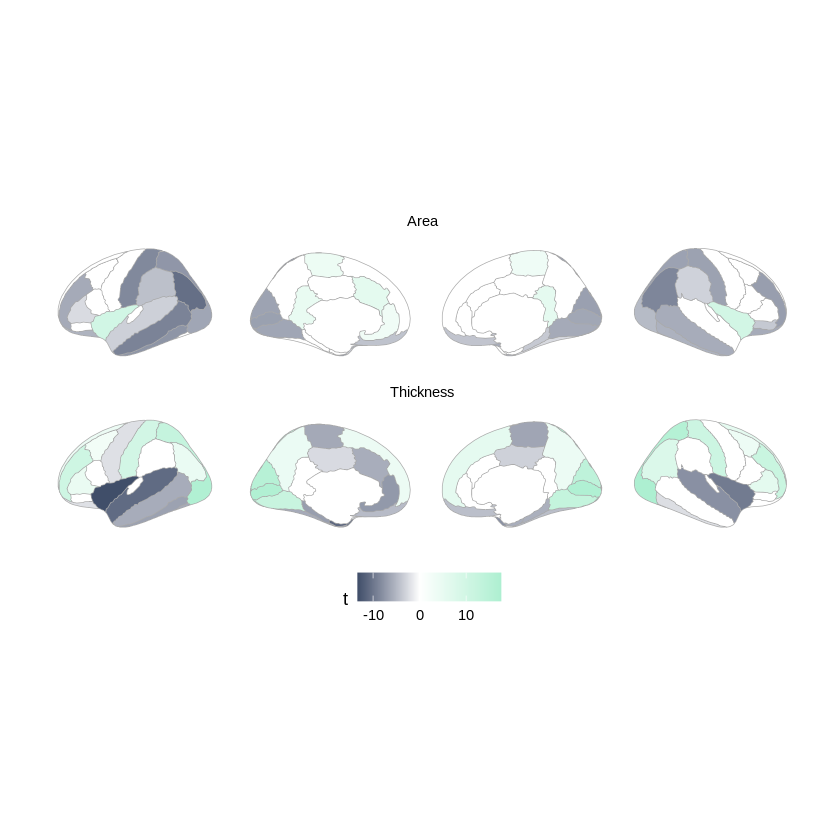

Warning message:
“Removed 15 rows containing non-finite values (`stat_boxplot()`).”


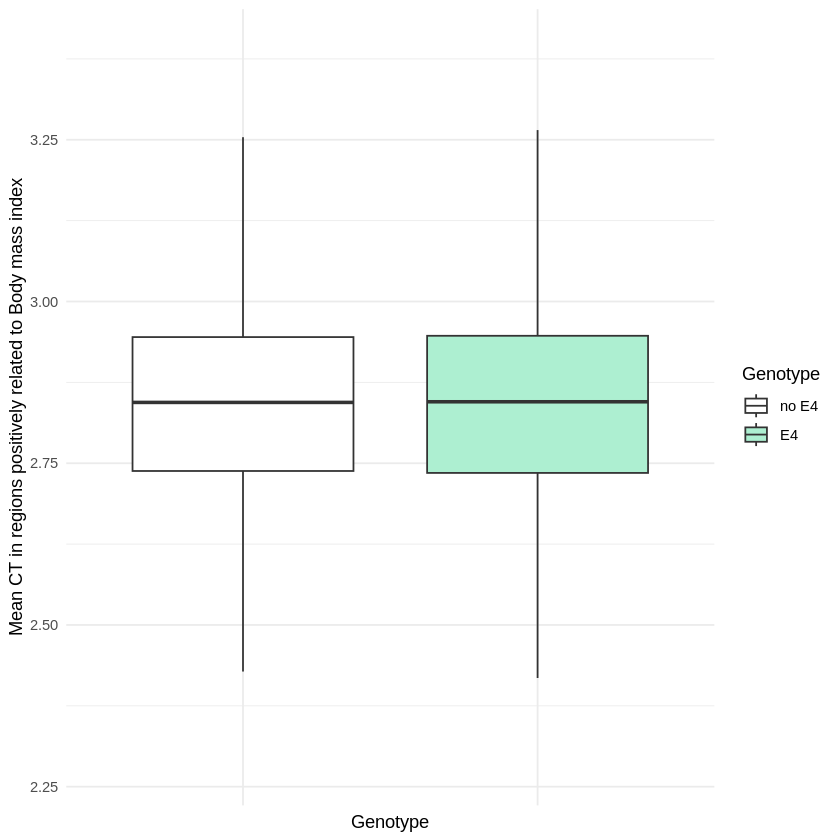

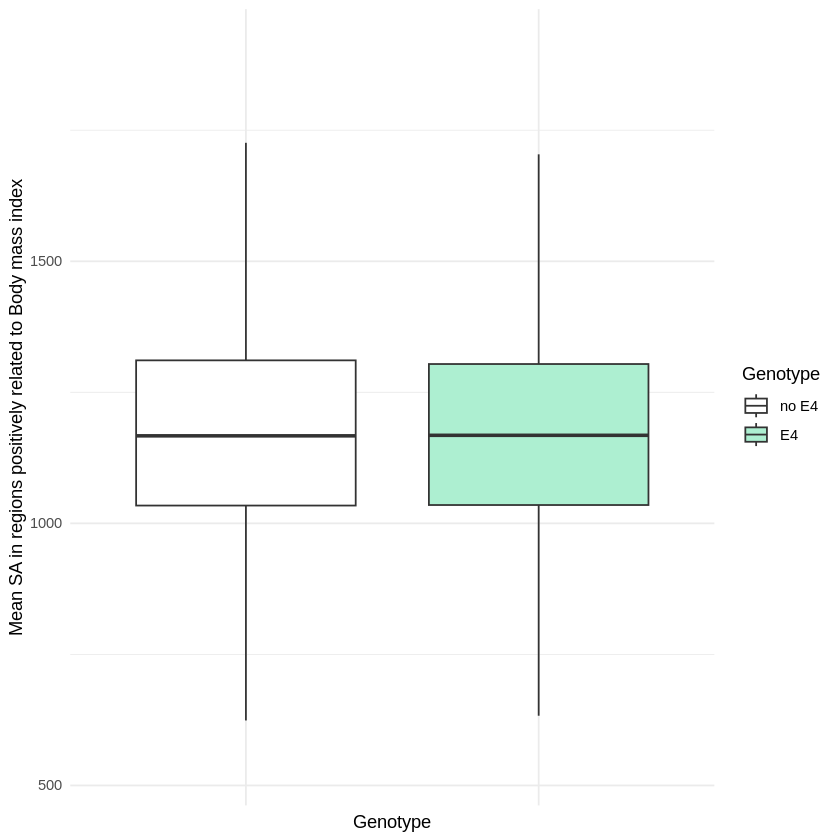

[[1]]
a flextable object.
col_keys: `region`, `hemi`, `p`, `t`, `Sample size`, `Partial_E2`, `phenotype` 
header has 1 row(s) 
body has 124 row(s) 
original dataset sample: 
                     region hemi         p       t Sample size Partial_E2
1 caudal anterior cingulate left 8.251e-09  5.9482       33709     0.0021
2     caudal middle frontal left    0.1955 -1.3918       33700     0.0028
3                    cuneus left 2.208e-10 -6.5735       33714     0.0093
4                entorhinal left    0.6178 -0.5419       33666     0.0002
5                  fusiform left    0.0682 -2.0142       33720     0.0178
  phenotype
1      Area
2      Area
3      Area
4      Area
5      Area

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]
                        region         p        t   Estimate     SE  hemi
1    caudal anterior cingulate 8.251e-09   5.9482     1.3181 0.2216  left
2        caudal middle frontal    0.1955  -1.3918    -0.6393 0.4594  left
3                       cuneus 2.208e-10  -6.5

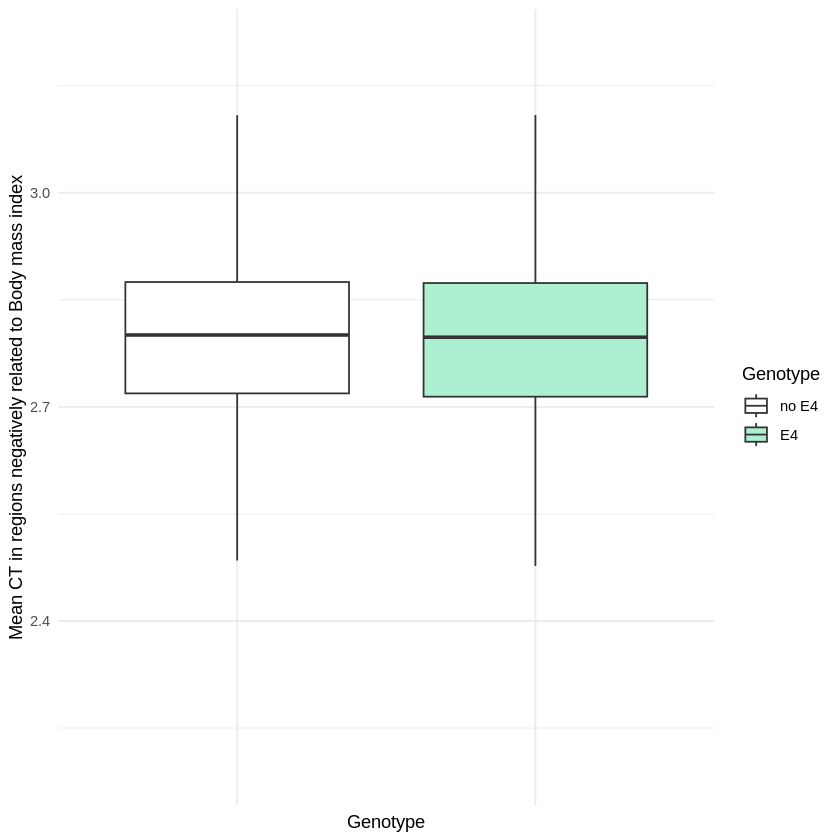

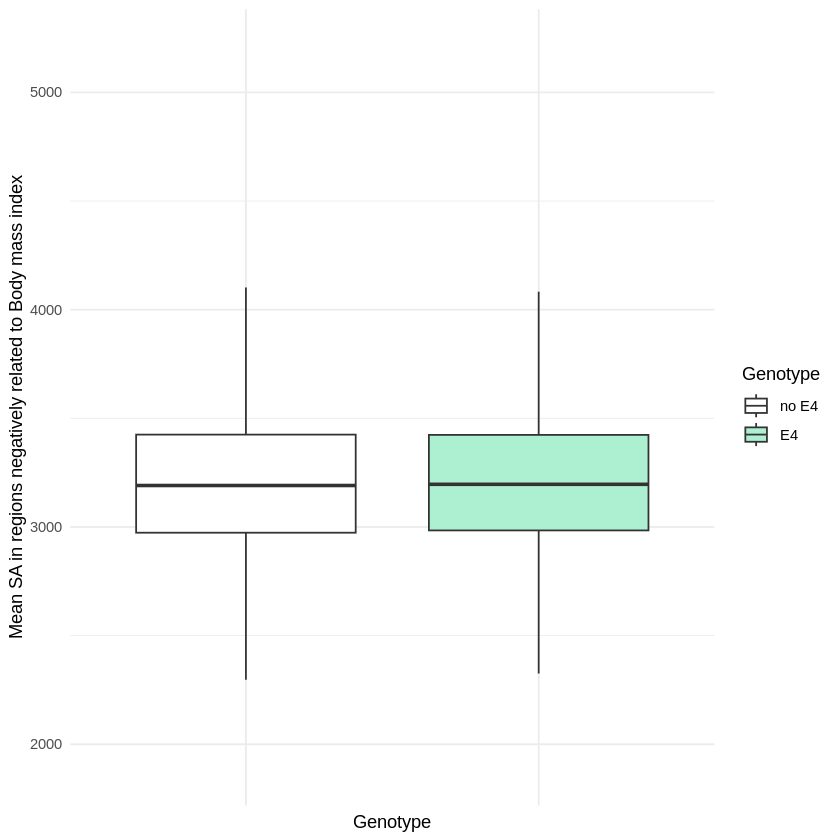

In [23]:
cortex_E4_main_body_mass_index_bmi_21001.2.0

In [ ]:
phen=c('cortex', 'subcortex')
genotype=c('E4','H1','AD_PRS')
term=c('main','int')
VoI=c('body_mass_index_bmi_21001.2.0','pca1') #'rs57223657','rs6760139', 
label=c('Body mass index','RC 1')

for (p in 1:length(phen)){
    for (g in 1:length(genotype)){
        for (t in 1:length(term)){
            for (v in 1:length(VoI)){

                assign(paste(phen[p], genotype[g], term[t], VoI[v], sep='_'), 
                        ctx_model(phen[p], genotype[g], term[t], VoI[v], label[v]))
                }
            }       
        }
    }

In [26]:
phen=c('cortex', 'subcortex')
genotype=c('E4','H1','AD_PRS')
term=c('main','int')
VoI=c('body_mass_index_bmi_21001.2.0','pca1') #'rs57223657','rs6760139', 
label=c('Body mass index','RC 1')

for (p in 1:length(phen)){
    for (g in 1:length(genotype)){
        for (t in 1:length(term)){
            for (v in 1:length(VoI)){

                assign(paste(phen[p], genotype[g], term[t], VoI[v], sep='_'), 
                        ctx_model(phen[p], genotype[g], term[t], VoI[v], label[v]))
                }
            }       
        }
    }

Warning message:
“Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead.”


In [27]:
save_as_docx(cortex_E4_main_body_mass_index_bmi_21001.2.0[[1]], subcortex_E4_main_body_mass_index_bmi_21001.2.0[[1]],
             cortex_E4_int_body_mass_index_bmi_21001.2.0[[1]], 
             cortex_H1_int_body_mass_index_bmi_21001.2.0[[1]], cortex_AD_PRS_int_body_mass_index_bmi_21001.2.0[[1]], 
              subcortex_E4_int_body_mass_index_bmi_21001.2.0[[1]], 
             subcortex_H1_int_body_mass_index_bmi_21001.2.0[[1]], subcortex_AD_PRS_int_body_mass_index_bmi_21001.2.0[[1]],
             cortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]],
             cortex_E4_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             cortex_H1_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             cortex_AD_PRS_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_E4_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_H1_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]],
             subcortex_AD_PRS_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]],
             cortex_E4_main_pca1[[1]], subcortex_E4_main_pca1[[1]], 
             cortex_E4_int_pca1[[1]], 
             cortex_H1_int_pca1[[1]], cortex_AD_PRS_int_pca1[[1]],
             subcortex_E4_int_pca1[[1]], 
             subcortex_H1_int_pca1[[1]], subcortex_AD_PRS_int_pca1[[1]],
             path='/dagher/dagher11/filip/MAPT_OB/Tables/GM_Tables_function_BMI_focus_AD_PRS.docx')

ERROR: Error in eval(expr, envir, enclos): object 'cortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0' not found


In [54]:
phen=c('cortex', 'subcortex')
genotype=c('E4','H1')
term=c('main','int')
VoI=c('body_mass_index_bmi_21001.2.0', 
     'total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0','body_fat_percentage_23099.2.0','WHR')
label=c('Body mass index','White matter hyperintensities','BF%','WHR')

for (p in 1:length(phen)){
    for (g in 1:length(genotype)){
        for (t in 1:length(term)){
            for (v in 1:length(VoI)){

                assign(paste(phen[p], genotype[g], term[t], VoI[v], sep='_'), 
                        ctx_model(phen[p], genotype[g], term[t], VoI[v], label[v]))
                }
            }       
        }
    }

In [55]:
save_as_docx(cortex_E4_main_body_mass_index_bmi_21001.2.0[[1]], cortex_E4_int_body_mass_index_bmi_21001.2.0[[1]], 
             cortex_H1_int_body_mass_index_bmi_21001.2.0[[1]], 
             subcortex_E4_main_body_mass_index_bmi_21001.2.0[[1]], subcortex_E4_int_body_mass_index_bmi_21001.2.0[[1]], 
             subcortex_H1_int_body_mass_index_bmi_21001.2.0[[1]],
             cortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             cortex_E4_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             cortex_H1_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_E4_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]], 
             subcortex_H1_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[1]],
             cortex_E4_main_body_fat_percentage_23099.2.0[[1]], cortex_E4_int_body_fat_percentage_23099.2.0[[1]], 
             cortex_H1_int_body_fat_percentage_23099.2.0[[1]], 
             subcortex_E4_main_body_fat_percentage_23099.2.0[[1]], subcortex_E4_int_body_fat_percentage_23099.2.0[[1]], 
             subcortex_H1_int_body_fat_percentage_23099.2.0[[1]],
             cortex_E4_main_WHR[[1]], cortex_E4_int_WHR[[1]], 
             cortex_H1_int_WHR[[1]], 
             subcortex_E4_main_WHR[[1]], subcortex_E4_int_WHR[[1]], 
             subcortex_H1_int_WHR[[1]],
             path='/dagher/dagher11/filip/MAPT_OB/Tables/GM_Tables_function_BMI_WHR_BFP.docx')

## Cognitive associations

In [204]:
genotype=c('E4','H1','AD_PRS')
term=c('main','int')
VoI=c('body_mass_index_bmi_21001.2.0', 
     'total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0','pca1')

for (g in 1:length(genotype)){
    for (t in 1:length(term)){
        for (v in 1:length(VoI)){
                
            assign(paste(genotype[g], term[t], VoI[v], sep='_'), 
                    cog_model(genotype[g], term[t], VoI[v]))
                
            
        }       
    }
}

- Term 'main' will always return plots and tables for the VoI only and not genetics, because that is more important here

In [205]:
save_as_docx(E4_main_body_mass_index_bmi_21001.2.0, E4_int_body_mass_index_bmi_21001.2.0, 
             H1_int_body_mass_index_bmi_21001.2.0, AD_PRS_int_body_mass_index_bmi_21001.2.0,
             E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0, 
             E4_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0, 
             H1_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0,
             AD_PRS_int_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0,
             E4_main_pca1, E4_int_pca1, 
             H1_int_pca1, AD_PRS_int_pca1,
             path='/dagher/dagher11/filip/MAPT_OB/Tables/Cog_Tables_function_BMI_focus_AD_PRS.docx')

In [43]:
genotype=c('rs7412')
term=c('main')
VoI=c('E4','H1','AD_PRS')

for (g in 1:length(genotype)){
    for (t in 1:length(term)){
        for (v in 1:length(VoI)){
                
            assign(paste(genotype[g], term[t], VoI[v], sep='_'), 
                    cog_model(genotype[g], term[t], VoI[v]))
                
            
        }       
    }
}

save_as_docx(rs7412_main_E4, rs7412_main_H1, rs7412_main_AD_PRS, 
             path='/dagher/dagher11/filip/MAPT_OB/Tables/Cog_Tables_GENETICS.docx')

# Correlation of APOE4/MAPT brain map with amyloid/tau map + with cell-specific gene expression

## Read in packages for spin tests

In [154]:
source("/dagher/dagher11/filip/Software/rotate_parcellation/R/perm.sphere.p.R")
source("/dagher/dagher11/filip/Software/rotate_parcellation/R/rotate.parcellation.R")

In [155]:
amyloid=c(0.42307589, 0.43821604,0.27832654,0.13792826,0.34242532,0.4655474,0.43592951,
0.32543542,0.40300421,0.30428422,0.4261153,0.24937009,0.4867927,0.44308223,0.34912991,
0.2063827,0.42481983,0.44571424,0.43345765,0.31010989,0.31120999,0.49096764,0.28417289,
0.5524801,0.48409009,0.53447225,0.46038992,0.40673786,0.37977172,0.43856865,0.34580301,
0.44025162,0.43777316,0.27532236,0.13209678,0.33495502,0.47979976,0.43046158,0.33467261,
0.40357215,0.31724805,0.42111977,0.2464843,0.50456126,0.4458489,0.34595968,0.20939865,
0.42978596,0.46389543,0.44211144,0.3286671,0.31127205,0.48978672,0.28914124,0.53541061,
0.4784875,0.54270811,0.46145932,0.3951592,0.37729085,0.42214311,0.32533372)

In [156]:
tau=c(1.13974106e+00, 3.88694712e+00,
       2.39511371e+00, 5.53503271e+00, 5.38190645e+00, 5.62174550e+00,
       6.46472202e+00, 3.82113160e+00, 4.09139808e+00, 2.02190950e+00,
       2.86058562e+00, 1.33826878e+00, 5.88404469e+00, 3.96643209e+00,
       1.09396560e+00, 2.58822830e+00, 1.62682463e+00, 2.18356348e+00,
       1.34253965e+00, 1.87654946e+00, 2.79856270e+00, 2.31431810e+00,
       3.85138689e+00, 1.36745723e+00, 3.08617677e+00, 2.58048517e+00,
       3.78359833e+00, 3.70438113e+00, 4.25749330e+00, 2.08060858e+00,
       1.83264941e+00, 1.32151448e+00, 3.60782540e+00, 2.64397057e+00,
       5.10105331e+00, 5.35011769e+00, 5.29500462e+00, 6.26608248e+00,
       3.90458355e+00, 4.18040327e+00, 1.95614101e+00, 2.74218305e+00,
       1.50811528e+00, 5.75832020e+00, 4.39307546e+00, 1.28910970e+00,
       2.47746555e+00, 1.60182662e+00, 2.08189763e+00, 1.79592073e+00,
       1.84113443e+00, 2.79200414e+00, 2.06274244e+00, 4.13677223e+00,
       1.05959101e+00, 2.58825114e+00, 2.38333756e+00, 3.17815187e+00,
       3.42950200e+00, 4.04442488e+00, 1.62788138e+00, 1.81627956e+00)

In [157]:
cells=list()

files=c('Mean_Gene_62R_DKT_Oligo_Exact.csv','Mean_Gene_62R_DKT_Astro_Exact.csv','Mean_Gene_62R_DKT_Micro_Exact.csv',
       'Mean_Gene_62R_DKT_NeuroEx_Exact.csv', 'Mean_Gene_62R_DKT_NeuroIn_Exact.csv','Mean_Gene_62R_DKT_OPC_Exact.csv')

for (i in 1:6){

    cells[[i]]=read.table(paste('~/Downloads/',files[i],sep=''))
    
    }

## Medioids

In [158]:
Medioids=read.table('/dagher/dagher11/filip/OBAD/data/DKT31_vol_coords.csv', sep=',',header=T)
Cort_medioids=Medioids[35:96,]
Cort_medioids=select(Cort_medioids, medoid_x_mni, medoid_y_mni, medoid_z_mni)

## ApoE4 correlations and spin test significance

In [169]:
APOE4=cortex_E4_main_body_mass_index_bmi_21001.2.0[[5]]
MAPT=cortex_H1_main_body_mass_index_bmi_21001.2.0[[5]]

In [170]:
#perm.id=rotate.parcellation(coord.l=as.matrix(Cort_medioids[c(1:31),]), coord.r=as.matrix(Cort_medioids[32:62,]), nrot=10000)
index=1

est=matrix(nrow=16,ncol=4)
dis_list=list()
dis=matrix(ncol=3,nrow=10000)

cat(cor.test(amyloid, as.numeric(APOE4$t[1:62]),method='spearman')$estimate,
    perm.sphere.p(amyloid, as.numeric(APOE4$t[1:62]), perm.id), '\n',
cor.test(amyloid, as.numeric(APOE4$t[63:124]),method='spearman')$estimate,
    perm.sphere.p(amyloid, as.numeric(APOE4$t[63:124]), perm.id),'\n')

cat(cor.test(tau, as.numeric(APOE4$t[1:62]),method='spearman')$estimate,
    perm.sphere.p(tau, as.numeric(APOE4$t[1:62]), perm.id), '\n',
cor.test(tau, as.numeric(APOE4$t[63:124]),method='spearman')$estimate,
    perm.sphere.p(tau, as.numeric(APOE4$t[63:124]), perm.id),'\n')

## Plotting
for (i in 1:10000){
        dis[i,1]=cor.test(amyloid[perm.id[,i]], as.numeric(APOE4$t[1:62]), method='spearman')$estimate
        dis[i,2]='Amyloid'
        dis[i,3]='SA'

    }
    dis=data.frame('distribution'=dis[,1], 'measure'=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[1]]=dis
for (i in 1:10000){
        dis[i,1]=cor.test(amyloid[perm.id[,i]], as.numeric(APOE4$t[63:124]), method='spearman')$estimate
        dis[i,2]='Amyloid'
        dis[i,3]='CT'

    }
    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[2]]=dis

## Plotting
for (i in 1:10000){
        dis[i,1]=cor.test(tau[perm.id[,i]], as.numeric(APOE4$t[1:62]), method='spearman')$estimate
        dis[i,2]='Tau'
        dis[i,3]='SA'

    }
    dis=data.frame('distribution'=dis[,1], 'measure'=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[3]]=dis
for (i in 1:10000){
        dis[i,1]=cor.test(tau[perm.id[,i]], as.numeric(APOE4$t[63:124]), method='spearman')$estimate
        dis[i,2]='Tau'
        dis[i,3]='CT'

    }
    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[4]]=dis

est[1,1]=cor.test(amyloid, as.numeric(APOE4$t[1:62]),method='spearman')$estimate
est[1,2]='Amyloid'
est[1,3]='SA'
est[1,4]=perm.sphere.p(amyloid, as.numeric(APOE4$t[1:62]), perm.id)

est[2,1]=cor.test(amyloid, as.numeric(APOE4$t[63:124]),method='spearman')$estimate
est[2,2]='Amyloid'
est[2,3]='CT'
est[2,4]=perm.sphere.p(amyloid, as.numeric(APOE4$t[63:124]), perm.id)

est[3,1]=cor.test(tau, as.numeric(APOE4$t[1:62]),method='spearman')$estimate
est[3,2]='Tau'
est[3,3]='SA'
est[3,4]=perm.sphere.p(tau, as.numeric(APOE4$t[1:62]), perm.id)

est[4,1]=cor.test(tau, as.numeric(APOE4$t[63:124]),method='spearman')$estimate
est[4,2]='Tau'
est[4,3]='CT'
est[4,4]=perm.sphere.p(tau, as.numeric(APOE4$t[63:124]), perm.id)

for (i in 1:6){
    
    cat(files[i],'\n')
    cat(cor.test(cells[[i]]$V1, as.numeric(APOE4$t[1:62]),method='spearman')$estimate,
        perm.sphere.p(cells[[i]]$V1, as.numeric(APOE4$t[1:62]), perm.id),'\n',
        cor.test(cells[[i]]$V1, as.numeric(APOE4$t[63:124]),method='spearman')$estimate,
        perm.sphere.p(cells[[i]]$V1, as.numeric(APOE4$t[63:124]), perm.id),'\n')
    ## Save variables for plotting
    for (k in 1:10000){
        dis[k,1]=cor.test(cells[[i]]$V1[perm.id[,k]], as.numeric(APOE4$t[1:62]), method='spearman')$estimate
        dis[k,2]=paste(files[i],'',sep='')    
        dis[k,3]='SA'

    }
    est[index+4,1]=cor.test(cells[[i]]$V1, as.numeric(APOE4$t[1:62]), method='spearman')$estimate
    est[index+4,2]=paste(files[i],'',sep='')
    est[index+4,3]='SA'
    est[index+4,4]=perm.sphere.p(cells[[i]]$V1, as.numeric(APOE4$t[1:62]), perm.id)


    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[index+4]]=dis
    
    for (k in 1:10000){
        dis[k,1]=cor.test(cells[[i]]$V1[perm.id[,k]], as.numeric(APOE4$t[63:124]), method='spearman')$estimate
        dis[k,2]=paste(files[i],'',sep='')
        dis[k,3]='CT'

    }
    est[index+5,1]=cor.test(cells[[i]]$V1, as.numeric(APOE4$t[63:124]), method='spearman')$estimate
    est[index+5,2]=paste(files[i],'',sep='')
    est[index+5,3]='CT'
    est[index+5,4]=perm.sphere.p(cells[[i]]$V1, as.numeric(APOE4$t[63:124]), perm.id)

    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[index+5]]=dis
    index=index+2
}

dis=do.call("rbind", dis_list)
est=data.frame(est)
est$X4[5:16]=as.numeric(p.adjust(est$X4[5:16], method='BH'))
est$X4[1:4]=as.numeric(p.adjust(est$X4[1:4], method='BH'))
est$sig[est$X4<0.05]='*'
est$X1=as.numeric(est$X1)
est$X4=as.numeric(est$X4)

-0.05955529 0.3618 
 -0.1657223 0.15065 
0.08237012 0.3696 
 -0.304223 0.0477 
Mean_Gene_62R_DKT_Oligo_Exact.csv 
0.02616404 0.4163 
 0.2032938 0.105 
Mean_Gene_62R_DKT_Astro_Exact.csv 
-0.5142404 0.00235 
 -0.2907255 0.07135 
Mean_Gene_62R_DKT_Micro_Exact.csv 
-0.3014026 0.1127 
 -0.1507643 0.211 
Mean_Gene_62R_DKT_NeuroEx_Exact.csv 
-0.4520914 0.00105 
 -0.2330085 0.14625 
Mean_Gene_62R_DKT_NeuroIn_Exact.csv 
-0.3328801 0.00275 
 -0.05023797 0.57075 
Mean_Gene_62R_DKT_OPC_Exact.csv 
-0.3897912 0.03245 
 -0.1934728 0.18635 


In [168]:
perm.id=rotate.parcellation(coord.l=as.matrix(Cort_medioids[c(1:31),]), coord.r=as.matrix(Cort_medioids[32:62,]), nrot=10000)


[1] "permutation 10 of 10000"
[1] "permutation 20 of 10000"
[1] "permutation 30 of 10000"
[1] "permutation 40 of 10000"
[1] "permutation 50 of 10000"
[1] "permutation 60 of 10000"
[1] "permutation 70 of 10000"
[1] "permutation 80 of 10000"
[1] "permutation 90 of 10000"
[1] "permutation 100 of 10000"
[1] "permutation 110 of 10000"
[1] "permutation 120 of 10000"
[1] "permutation 130 of 10000"
[1] "permutation 140 of 10000"
[1] "permutation 150 of 10000"
[1] "permutation 160 of 10000"
[1] "permutation 170 of 10000"
[1] "permutation 180 of 10000"
[1] "permutation 190 of 10000"
[1] "permutation 200 of 10000"
[1] "permutation 210 of 10000"
[1] "permutation 220 of 10000"
[1] "permutation 230 of 10000"
[1] "permutation 240 of 10000"
[1] "permutation 250 of 10000"
[1] "permutation 260 of 10000"
[1] "permutation 270 of 10000"
[1] "permutation 280 of 10000"
[1] "permutation 290 of 10000"
[1] "permutation 300 of 10000"
[1] "permutation 310 of 10000"
[1] "permutation 320 of 10000"
[1] "permutation 

In [171]:
est=est %>% 
 mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
colnames(est)=c('Correlation_coefficient','Measure','Phenotype','p-value','Sig')
tab1=flextable(est[,c(2,3,1,4)])
tab1=autofit(tab1,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
tab1=set_caption(tab1, caption = "Table S1 - ApoE correlations")

In [172]:
APOE_corr = ggplot(data=dis, aes(y=as.numeric(distribution), fill=measure, x=factor(measure,levels = c("Tau","Amyloid",
                              'Mean_Gene_62R_DKT_Astro_Exact.csv','Mean_Gene_62R_DKT_Micro_Exact.csv',
                              'Mean_Gene_62R_DKT_NeuroEx_Exact.csv', 'Mean_Gene_62R_DKT_NeuroIn_Exact.csv',
                              'Mean_Gene_62R_DKT_Oligo_Exact.csv','Mean_Gene_62R_DKT_OPC_Exact.csv')))) + 
    geom_violin() + 
    scale_fill_manual(values=c('#00203FFF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#00203FFF')) +
    stat_summary(fun.data=mean_sdl, geom="pointrange", color="white") +
    facet_wrap(~pheno)  +
    geom_point(data = data.frame(est), mapping = aes(x = Measure, y = as.numeric(Correlation_coefficient), fill=NULL), size=3, 
               colour='#6495ad') + 
    facet_wrap(~data.frame(est)$Phenotype) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90)) +
    ylab('Correlation coefficient') +
    xlab('Phenotype') +
    scale_x_discrete(labels=c("Tau",'Amyloid',"Astrocytes", "Microglia", "Excitatory neurons","Inhibitory neurons",
                             "Oligodendrocytes","OPC")) +
    geom_text(data=est, mapping=aes(label = Sig, x=Measure, y=0.75, fill=NULL)) +
    theme(legend.position = "none")

## MAPT correlations and spin test significance

In [173]:
#perm.id=rotate.parcellation(coord.l=as.matrix(Cort_medioids[c(1:31),]), coord.r=as.matrix(Cort_medioids[32:62,]), nrot=10000)
index=1

est=matrix(nrow=16,ncol=4)
dis_list=list()
dis=matrix(ncol=3,nrow=10000)

cat(cor.test(amyloid, as.numeric(MAPT$t[1:62]),method='spearman')$estimate,
    perm.sphere.p(amyloid, as.numeric(MAPT$t[1:62]), perm.id), '\n',
cor.test(amyloid, as.numeric(MAPT$t[63:124]),method='spearman')$estimate,
    perm.sphere.p(amyloid, as.numeric(MAPT$t[63:124]), perm.id),'\n')

cat(cor.test(tau, as.numeric(MAPT$t[1:62]),method='spearman')$estimate,
    perm.sphere.p(tau, as.numeric(MAPT$t[1:62]), perm.id), '\n',
cor.test(tau, as.numeric(MAPT$t[63:124]),method='spearman')$estimate,
    perm.sphere.p(tau, as.numeric(MAPT$t[63:124]), perm.id),'\n')

## Plotting
for (i in 1:10000){
        dis[i,1]=cor.test(amyloid[perm.id[,i]], as.numeric(MAPT$t[1:62]), method='spearman')$estimate
        dis[i,2]='Amyloid'
        dis[i,3]='SA'

    }
    dis=data.frame('distribution'=dis[,1], 'measure'=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[1]]=dis
for (i in 1:10000){
        dis[i,1]=cor.test(amyloid[perm.id[,i]], as.numeric(MAPT$t[63:124]), method='spearman')$estimate
        dis[i,2]='Amyloid'
        dis[i,3]='CT'

    }
    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[2]]=dis

## Plotting
for (i in 1:10000){
        dis[i,1]=cor.test(tau[perm.id[,i]], as.numeric(MAPT$t[1:62]), method='spearman')$estimate
        dis[i,2]='Tau'
        dis[i,3]='SA'

    }
    dis=data.frame('distribution'=dis[,1], 'measure'=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[3]]=dis
for (i in 1:10000){
        dis[i,1]=cor.test(tau[perm.id[,i]], as.numeric(MAPT$t[63:124]), method='spearman')$estimate
        dis[i,2]='Tau'
        dis[i,3]='CT'

    }
    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[4]]=dis

est[1,1]=cor.test(amyloid, as.numeric(MAPT$t[1:62]),method='spearman')$estimate
est[1,2]='Amyloid'
est[1,3]='SA'
est[1,4]=perm.sphere.p(amyloid, as.numeric(MAPT$t[1:62]), perm.id)

est[2,1]=cor.test(amyloid, as.numeric(MAPT$t[63:124]),method='spearman')$estimate
est[2,2]='Amyloid'
est[2,3]='CT'
est[2,4]=perm.sphere.p(amyloid, as.numeric(MAPT$t[63:124]), perm.id)

est[3,1]=cor.test(tau, as.numeric(MAPT$t[1:62]),method='spearman')$estimate
est[3,2]='Tau'
est[3,3]='SA'
est[3,4]=perm.sphere.p(tau, as.numeric(MAPT$t[1:62]), perm.id)

est[4,1]=cor.test(tau, as.numeric(MAPT$t[63:124]),method='spearman')$estimate
est[4,2]='Tau'
est[4,3]='CT'
est[4,4]=perm.sphere.p(tau, as.numeric(MAPT$t[63:124]), perm.id)

for (i in 1:6){
    
    cat(files[i],'\n')
    cat(cor.test(cells[[i]]$V1, as.numeric(MAPT$t[1:62]),method='spearman')$estimate,
        perm.sphere.p(cells[[i]]$V1, as.numeric(MAPT$t[1:62]), perm.id),'\n',
        cor.test(cells[[i]]$V1, as.numeric(MAPT$t[63:124]),method='spearman')$estimate,
        perm.sphere.p(cells[[i]]$V1, as.numeric(MAPT$t[63:124]), perm.id),'\n')
    ## Save variables for plotting
    for (k in 1:10000){
        dis[k,1]=cor.test(cells[[i]]$V1[perm.id[,k]], as.numeric(MAPT$t[1:62]), method='spearman')$estimate
        dis[k,2]=paste(files[i],'',sep='')    
        dis[k,3]='SA'

    }
    est[index+4,1]=cor.test(cells[[i]]$V1, as.numeric(MAPT$t[1:62]), method='spearman')$estimate
    est[index+4,2]=paste(files[i],'',sep='')
    est[index+4,3]='SA'
    est[index+4,4]=perm.sphere.p(cells[[i]]$V1, as.numeric(MAPT$t[1:62]), perm.id)


    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[index+4]]=dis
    
    for (k in 1:10000){
        dis[k,1]=cor.test(cells[[i]]$V1[perm.id[,k]], as.numeric(MAPT$t[63:124]), method='spearman')$estimate
        dis[k,2]=paste(files[i],'',sep='')
        dis[k,3]='CT'

    }
    est[index+5,1]=cor.test(cells[[i]]$V1, as.numeric(MAPT$t[63:124]), method='spearman')$estimate
    est[index+5,2]=paste(files[i],'',sep='')
    est[index+5,3]='CT'
    est[index+5,4]=perm.sphere.p(cells[[i]]$V1, as.numeric(MAPT$t[63:124]), perm.id)

    dis=data.frame('distribution'=dis[,1], measure=dis[,2], 'pheno'=dis[,3]) 
    dis_list[[index+5]]=dis
    index=index+2
}

dis=do.call("rbind", dis_list)
est=data.frame(est)
est$X4[5:16]=as.numeric(p.adjust(est$X4[5:16], method='BH'))
est$X4[1:4]=as.numeric(p.adjust(est$X4[1:4], method='BH'))
est$sig[est$X4<0.05]='*'
est$X1=as.numeric(est$X1)
est$X4=as.numeric(est$X4)

0.05300798 0.38625 
 -0.2748105 0.03855 
0.3286999 0.03265 
 -0.3341392 0.01145 
Mean_Gene_62R_DKT_Oligo_Exact.csv 
-0.02490494 0.4399 
 0.224497 0.04315 
Mean_Gene_62R_DKT_Astro_Exact.csv 
-0.1580167 0.177 
 -0.2920853 0.02455 
Mean_Gene_62R_DKT_Micro_Exact.csv 
-0.4408602 0.0059 
 0.1044295 0.2031 
Mean_Gene_62R_DKT_NeuroEx_Exact.csv 
0.06378585 0.38075 
 -0.3223036 0.00885 
Mean_Gene_62R_DKT_NeuroIn_Exact.csv 
0.03497771 0.4225 
 -0.2890635 0.01485 
Mean_Gene_62R_DKT_OPC_Exact.csv 
-0.259097 0.0719 
 -0.1658734 0.1271 


In [177]:
est

Correlation_coefficient,Measure,Phenotype,p-value,Sig
<dbl>,<chr>,<chr>,<dbl>,<chr>
0.0530,Amyloid,SA,0.3862,NA
-0.2748,Amyloid,CT,0.0514,NA
0.3287,Tau,SA,0.0514,NA
-0.3341,Tau,CT,0.0458,*
-0.0249,Mean_Gene_62R_DKT_Oligo_Exact.csv,SA,0.4399,NA
0.2245,Mean_Gene_62R_DKT_Oligo_Exact.csv,CT,0.1036,NA
-0.1580,Mean_Gene_62R_DKT_Astro_Exact.csv,SA,0.2655,NA
-0.2921,Mean_Gene_62R_DKT_Astro_Exact.csv,CT,0.0736,NA
-0.4409,Mean_Gene_62R_DKT_Micro_Exact.csv,SA,0.0531,NA


In [174]:
est=est %>% 
 mutate_if(is.numeric, round_and_format, digits = 4, threshold = 0.0001)
colnames(est)=c('Correlation_coefficient','Measure','Phenotype','p-value','Sig')
tab2=flextable(est[,c(2,3,1,4)])
tab2=autofit(tab2,add_w = 0.1,add_h = 0.1,part = c("body", "header"),unit = "in")
tab2=set_caption(tab2, caption = "Table S2 - MAPT correlations")
#save_as_docx(tab1, tab2, path='/dagher/dagher11/filip/MAPT_OB/Tables/Spin_Tables.docx')

In [175]:
MAPT_corr = ggplot(data=dis, aes(y=as.numeric(distribution), fill=measure, x=factor(measure,levels = c("Tau","Amyloid",
                              'Mean_Gene_62R_DKT_Astro_Exact.csv','Mean_Gene_62R_DKT_Micro_Exact.csv',
                              'Mean_Gene_62R_DKT_NeuroEx_Exact.csv', 'Mean_Gene_62R_DKT_NeuroIn_Exact.csv',
                              'Mean_Gene_62R_DKT_Oligo_Exact.csv','Mean_Gene_62R_DKT_OPC_Exact.csv')))) + 
    geom_violin() + 
    scale_fill_manual(values=c('#00203FFF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#ADEFD1FF','#00203FFF')) +
    stat_summary(fun.data=mean_sdl, geom="pointrange", color="white") +
    facet_wrap(~pheno)  +
    geom_point(data = data.frame(est), mapping = aes(x = Measure, y = as.numeric(Correlation_coefficient), 
                                                     fill=NULL), size=3, colour='#6495ad') + 
    facet_wrap(~data.frame(est)$Phenotype) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90)) +
    ylab('Correlation coefficient') +
    xlab('Phenotype') +
    scale_x_discrete(labels=c("Tau",'Amyloid',"Astrocytes", "Microglia", "Excitatory neurons","Inhibitory neurons",
                             "Oligodendrocytes","OPC")) +
    geom_text(data=est, mapping=aes(label = Sig, x=Measure, y=0.75, fill=NULL)) +
    theme(legend.position = "none")

# Arrange all plots together

# Figure 1 + Genetic tables = tables of associations between MAPT/ApoE and genetics

In [52]:
phen=c('cortex', 'subcortex')
genotype=c('rs7412') # placeholder variable
term=c('main')
VoI=c('E4','H1','AD_PRS') #'rs57223657','rs6760139', 
label=c('E4','H1','AD PRS')

for (p in 1:length(phen)){
    for (g in 1:length(genotype)){
        for (t in 1:length(term)){
            for (v in 1:length(VoI)){

                assign(paste(phen[p], genotype[g], term[t], VoI[v], sep='_'), 
                        ctx_model(phen[p], genotype[g], term[t], VoI[v], label[v]))
                }
            }       
        }
    }

Warning message:
“Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead.”


In [38]:
png('/dagher/dagher11/filip/MAPT_OB//figures/Figure1.png',width=4000, height=3500, res=300)


ggarrange(ggarrange(cortex_rs7412_main_E4[[2]] + theme(text=element_text(size=15)), 
                    cortex_rs7412_main_H1[[2]] + theme(text=element_text(size=15)), ncol=1, labels=c("a",'c')), 
          ggarrange(subcortex_rs7412_main_E4[[2]] + theme(text=element_text(size=15)),
                    subcortex_rs7412_main_H1[[2]] + theme(text=element_text(size=15)), ncol=1, labels=c("b","d")),
          ncol = 2, nrow = 1, widths=c(3,1))
dev.off()

merging atlas and data by 'region', 'hemi'

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' n

png 
  2

In [44]:
save_as_docx(cortex_rs7412_main_E4[[1]], subcortex_rs7412_main_E4[[1]], cortex_rs7412_main_H1[[1]], subcortex_rs7412_main_H1[[1]],
             cortex_rs7412_main_AD_PRS[[1]], subcortex_rs7412_main_AD_PRS[[1]],
             path='/dagher/dagher11/filip/MAPT_OB/Tables/GM_Tables_GENETICS.docx')

## Figure 3

In [29]:
png('/dagher/dagher11/filip/MAPT_OB//figures/Figure3.png',width=4000, height=3500, res=300)
ggarrange(ggarrange(cortex_E4_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), 
                    subcortex_E4_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), ncol=2, labels=c("a",'b'),
                   widths=c(3,1)), 
          ggarrange(cortex_E4_main_body_mass_index_bmi_21001.2.0[[3]] + theme(text=element_text(size=15)),
                    cortex_E4_main_body_mass_index_bmi_21001.2.0[[4]] + theme(text=element_text(size=15)), 
                    cortex_H1_main_body_mass_index_bmi_21001.2.0[[3]] + theme(text=element_text(size=15)), 
                    cortex_H1_main_body_mass_index_bmi_21001.2.0[[4]] + theme(text=element_text(size=15)), nrow=1, labels=c("c","d","e",'f')), 
          #labels = c("","","E","","","J"),
          ncol = 1, nrow = 2)
dev.off()

ERROR: Error in eval(expr, envir, enclos): object 'cortex_E4_main_body_mass_index_bmi_21001.2.0' not found


## Figure S2

In [168]:
nadata = filter(data, !is.na(data$E4)) 
WMH_hipp=ggplot(data=nadata, aes(x=total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0, 
                      y=volume_of_hippocampus_right_25020.2.0, colour=as.factor(E4), group=as.factor(E4))) +
geom_smooth(method=lm) + 
ylab('Hippocampal volume') + 
xlab('WMH load') + 
scale_color_manual(labels = c('no E4','E4'), values = c("white", "#ADEFD1FF")) +
guides(color=guide_legend(title="Genotype")) + theme_minimal()

nadata = filter(data, !is.na(data$H1)) 
WMH_pallidum=ggplot(data=nadata, aes(x=total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0, 
                      y=volume_of_pallidum_left_25017.2.0, colour=as.factor(H1), group=as.factor(H1))) +
geom_smooth(method=lm) + 
ylab('Pallidum volume') + 
xlab('WMH load') + 
scale_color_manual(labels = c('no H1','H1'), values = c("white", "#ADEFD1FF")) +
guides(color=guide_legend(title="Genotype")) + theme_minimal()

In [182]:
png('/dagher/dagher11/filip/MAPT_OB//figures/FigureS2.png',width=4000, height=3500, res=300)
ggarrange(ggarrange(cortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[2]] + theme(text=element_text(size=15)),
                   subcortex_E4_main_total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0[[2]] 
                    + theme(text=element_text(size=15)), widths=c(2,1), labels=c("a","b")), 
                    ggarrange(
                    WMH_hipp + theme(text=element_text(size=15)),
                    WMH_pallidum+ theme(text=element_text(size=15)), labels=c("c","d"), nrow=1, ncol=2 ),
          ncol = 1, nrow = 2, heights=c(1,1))
dev.off()

merging atlas and data by 'region', 'hemi'

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' n

png 
  2

## Figure S3

In [28]:
data_plot=cortex_E4_int_pca1[[1]]$body$dataset
data_plot$region=colnames(data[c(grep('area_of',colnames(data)), grep('area_of',colnames(data)))])
data_plot=subset(data_plot, t>0)
data$meanSA_sig_int=rowMeans(data[data_plot[data_plot$p<0.05,][as.numeric(grep('area', data_plot[data_plot$p<0.05,]$region)),]$region],na.rm=T)

na_dat=!is.na(data['E4'])
data$genotype_interest=data[['E4']]

SA_line_PCA = filter(data, na_dat & !is.na(data$genotype_interest)) %>% 
                ggplot(aes(x=pca1, y=meanSA_sig_int, colour=as.factor(genotype_interest))) + 
                    geom_smooth(method='lm') +
                    ylab('Mean SA in all significant regions') + 
                    xlab('RC 1') + 
                    scale_color_manual(labels = c('no E4','E4'), values = c("white", "#ADEFD1FF")) +
                    guides(color=guide_legend(title="Genotype")) + 
                    theme_minimal()

In [29]:
nadata = filter(data, !is.na(data$E4)) 
PCA_insula=ggplot(data=nadata, aes(x=pca1, 
                      y=area_of_insula_left_hemisphere_27173.2.0, colour=as.factor(E4), group=as.factor(E4))) +
geom_smooth(method=lm) + 
ylab('Insula volume') + 
xlab('RC1') + 
scale_color_manual(labels = c('no E4','E4'), values = c("white", "#ADEFD1FF")) +
guides(color=guide_legend(title="Genotype")) 

In [30]:
png('/dagher/dagher11/filip/MAPT_OB//figures/FigureS3.png',width=4000, height=3500, res=300)
ggarrange(ggarrange(cortex_E4_main_pca1[[2]] + theme(text=element_text(size=15)),
                   subcortex_E4_main_pca1[[2]] + theme(text=element_text(size=15)), labels=c("a","b"), ncol=2, widths=c(2,1)), 
          ggarrange(cortex_E4_int_pca1[[2]] + theme(text=element_text(size=15)),
                    SA_line_PCA + theme(text=element_text(size=15)), labels=c("c","d"), nrow=1, ncol=2, widths=c(2,1)),
          ncol = 1, nrow = 2)
dev.off()

merging atlas and data by 'region', 'hemi'

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found in PostScript font database”
Warning message in grid.C

png 
  2

## Figure S5

In [201]:
png('/dagher/dagher11/filip/MAPT_OB//figures/FigureS5.png',width=2500, height=2000, res=300)
nadata = filter(data, !is.na(data$E4))
ggplot(data=nadata, aes(x=total_volume_of_white_matter_hyperintensities_from_t1_and_t2_flair_images_25781.2.0, 
                      y=Prospective_memory, colour=as.factor(E4), group=as.factor(E4))) +
geom_smooth(method=lm) + 
ylab('Prospective memory') + 
xlab('WMH load') + 
scale_color_manual(labels = c('no E4','E4'), values = c("white", "#ADEFD1FF")) +
guides(color=guide_legend(title="Genotype")) + theme_minimal()
dev.off()

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 5437 rows containing non-finite values (`stat_smooth()`).”


png 
  2

## Figure S6

In [30]:
png('/dagher/dagher11/filip/MAPT_OB//figures/FigureS6.png',width=2500, height=2000, res=300)
nadata = filter(data, !is.na(data$H1))
ggplot(data=nadata, aes(x=pca1, 
                      y=Pairs, colour=as.factor(H1), group=as.factor(H1))) +
geom_smooth(method=lm) + 
ylab('Visuospatial memory') + 
xlab('RC 1') + 
scale_color_manual(labels = c('no H1','H1'), values = c("white", "#ADEFD1FF")) +
guides(color=guide_legend(title="Genotype")) + theme_minimal()
dev.off()

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 12769 rows containing non-finite values (`stat_smooth()`).”


png 
  2

## Old stuff from genotype = focus

In [176]:
tiff('/dagher/dagher11/filip/MAPT_OB/GM_Figure_function_updated.tiff',width=7000, height=7000, res=300)
ggarrange(ggarrange(cortex_E4_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), 
                    subcortex_E4_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), nrow=2, labels=c("A",'B')), 
          ggarrange(cortex_E4_main_body_mass_index_bmi_21001.2.0[[3]] + theme(text=element_text(size=15)), 
                    cortex_E4_main_body_mass_index_bmi_21001.2.0[[4]] + theme(text=element_text(size=15)), nrow=2, labels=c("C",'D')), 
          APOE_corr + theme(text=element_text(size=15)),
          ggarrange(cortex_H1_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), 
                    subcortex_H1_main_body_mass_index_bmi_21001.2.0[[2]] + theme(text=element_text(size=15)), nrow=2, labels=c("F",'G')), 
          ggarrange(cortex_H1_main_body_mass_index_bmi_21001.2.0[[3]] + theme(text=element_text(size=15)), 
                    cortex_H1_main_body_mass_index_bmi_21001.2.0[[4]] + theme(text=element_text(size=15)), nrow=2, labels=c("H",'I')), 
          MAPT_corr + theme(text=element_text(size=15)),
          labels = c("","","E","","","J"),
          ncol = 3, nrow = 2)
dev.off()

merging atlas and data by 'region', 'hemi'

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' n

png 
  2